In [1]:
import pandas as pd
from glob import glob
import numpy as np

In [76]:
path = "data/tickers/spx_group_sector.csv"
df = pd.read_csv(path)
df = df.loc[df.field == "INDUSTRY_SECTOR"].reset_index(drop=True)
df.loc[:, "ticker"] = df.ticker.map(lambda x: x.replace("/", " "))
df.head()

,Unnamed: 0,ticker,field,value,exchange,stock
0,0,0111145D UN Equity,INDUSTRY_SECTOR,Utilities,UN,0111145D
1,1,0202445Q UN Equity,INDUSTRY_SECTOR,"Consumer, Non-cyclical",UN,0202445Q
2,2,0203524D UN Equity,INDUSTRY_SECTOR,Technology,UN,0203524D
3,3,0226226D UN Equity,INDUSTRY_SECTOR,"Consumer, Cyclical",UN,0226226D
4,4,0544749D UN Equity,INDUSTRY_SECTOR,Energy,UN,0544749D


## Find problematic tickers (tickers with gaps)

<AxesSubplot:xlabel='year'>

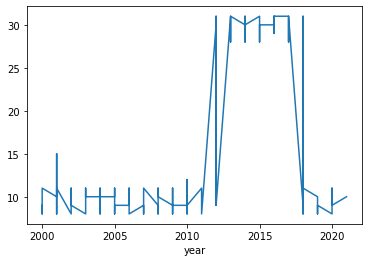

In [77]:
group_stock_df.sort_index()['count'].plot()

In [130]:
new_stock_df

,ADI UW Equity
date,
2012-04-04,-0.9980
2012-04-05,0.2585
2012-04-06,NaN
2012-04-07,NaN
2012-04-08,NaN
...,...
2021-01-22,-2.3291
2021-01-23,NaN
2021-01-24,NaN


In [ ]:
ticker_paths = glob('data/tickers/spx/*.csv')

tickers_to_skip = []
for p in tickers_paths:
    stock_df = pd.read_csv(p)
    stock_df = stock_df.drop([0,1,2], 0)
    stock_df.rename(columns={'ticker': 'date'}, inplace=True)
    stock_df.index = pd.to_datetime(stock_df['date'])
    stock_df = stock_df.drop('date', 1)
    stock_df[stock_df.columns[0]] = stock_df[stock_df.columns[0]].astype(float)
    stock_df = stock_df.resample('D').mean()
    
    stock_df['month'] = [dt_ref.month for dt_ref in stock_df.index]
    stock_df['year'] = [dt_ref.year for dt_ref in stock_df.index]
    stock_df['count'] = [1 if pd.isna(val) else 0 for val in stock_df[stock_df.columns[0]]]

    group_stock_df = stock_df.groupby(['month', 'year']).sum()['count'].reset_index()
    group_stock_df.index = group_stock_df['year']
    group_stock_df = group_stock_df.sort_index() 
    group_stock_df['count'].median()

    median = group_stock_df['count'].median() 
    std = group_stock_df['count'].std()
    if np.sum(np.where(group_stock_df['count'] > (median+ 3 * std), 1, 0)) > 10:
        stock = p.split('/')[3].split(' ')[0]
        exchange = p.split('/')[3].split(' ')[1]
        new_stock = df.loc[(df['stock'] == stock)&(df['exchange'] != exchange)]['ticker'].iloc[0]

        new_stock_df = pd.read_csv(os.path.join('data', 'tickers', 'spx', new_stock + '.csv'))
        new_stock_df = new_stock_df.drop([0,1,2], 0)
        new_stock_df.rename(columns={'ticker': 'date'}, inplace=True)
        new_stock_df.index = pd.to_datetime(new_stock_df['date'])
        new_stock_df = new_stock_df.drop('date', 1)
        new_stock_df[new_stock_df.columns[0]] = new_stock_df[new_stock_df.columns[0]].astype(float)
        new_stock_df = new_stock_df.resample('D').mean()

        adj_stock_df = pd.concat([new_stock_df.drop(['month', 'year', 'count'], 1), new_stock_df], axis=1)

        adj_stock_df[adj_stock_df.columns[1]] = [row[adj_stock_df.columns[0]] if pd.isna(row[adj_stock_df.columns[1]]) else row[adj_stock_df.columns[1]] for i, row in adj_stock_df.iterrows()]
        adj_stock_df = adj_stock_df.drop(adj_stock_df.columns[0], 1)